# MIMIC-III Mortality Pipeline (EDA -> FE -> Models)
Keeping the full story: EDA, rationale, severity features, and the final modeling path.


**Run notes (Majo voice)**
- `EDA = True` to see plots and summaries; set to False for quick runs.
- Data lives in `MIMIC III dataset HEF`; diagnoses in `extra_data`.
- Output file: `argote_mariajose_CML_2025.csv` with probability preds.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path

from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone

try:
    from xgboost import XGBClassifier
    HAS_XGB = True
except ImportError:
    HAS_XGB = False

warnings.filterwarnings("ignore")
plt.style.use("seaborn-v0_8")


In [3]:
RANDOM_STATE = 42
DATA_DIR = Path("MIMIC III dataset HEF")
TRAIN_PATH = DATA_DIR / "mimic_train_HEF.csv"
TEST_PATH = DATA_DIR / "mimic_test_HEF.csv"
DIAGNOSES_PATH = DATA_DIR / "extra_data" / "MIMIC_diagnoses.csv"

EDA = True  # flip to False for speed
pd.set_option("display.max_columns", None)


### 1. Load data


In [4]:
train_raw = pd.read_csv(TRAIN_PATH)
test_raw = pd.read_csv(TEST_PATH)
diagnoses_raw = pd.read_csv(DIAGNOSES_PATH)

print(f"train shape: {train_raw.shape}")
print(f"test shape:  {test_raw.shape}")
print(f"diagnoses shape: {diagnoses_raw.shape}")
train_raw.head()


train shape: (20885, 44)
test shape:  (5221, 39)
diagnoses shape: (651047, 4)


,HOSPITAL_EXPIRE_FLAG,subject_id,hadm_id,icustay_id,HeartRate_Min,HeartRate_Max,HeartRate_Mean,SysBP_Min,SysBP_Max,SysBP_Mean,DiasBP_Min,DiasBP_Max,DiasBP_Mean,MeanBP_Min,MeanBP_Max,MeanBP_Mean,RespRate_Min,RespRate_Max,RespRate_Mean,TempC_Min,TempC_Max,TempC_Mean,SpO2_Min,SpO2_Max,SpO2_Mean,Glucose_Min,Glucose_Max,Glucose_Mean,GENDER,DOB,DOD,ADMITTIME,DISCHTIME,DEATHTIME,Diff,ADMISSION_TYPE,INSURANCE,RELIGION,MARITAL_STATUS,ETHNICITY,DIAGNOSIS,ICD9_diagnosis,FIRST_CAREUNIT,LOS
0,0,55440,195768,228357,89.0,145.0,121.043478,74.0,127.0,106.586957,42.0,90.0,61.173913,59.0,94.0,74.543478,15.0,30.0,22.347826,35.111111,36.944444,36.080247,90.0,99.0,95.739130,111.0,230.0,160.777778,F,2108-07-16 00:00:00,2180-03-09 00:00:00,2178-02-06 10:35:00,2178-02-13 18:30:00,NaN,-61961.78470,EMERGENCY,Medicare,PROTESTANT QUAKER,SINGLE,WHITE,GASTROINTESTINAL BLEED,5789,MICU,4.5761
1,0,76908,126136,221004,63.0,110.0,79.117647,89.0,121.0,106.733333,49.0,74.0,64.733333,58.0,84.0,74.800000,13.0,21.0,16.058824,36.333333,36.611111,36.472222,98.0,100.0,99.058824,103.0,103.0,103.000000,F,2087-01-16 00:00:00,NaN,2129-02-12 22:34:00,2129-02-13 16:20:00,NaN,-43146.18378,EMERGENCY,Private,UNOBTAINABLE,MARRIED,WHITE,ESOPHAGEAL FOOD IMPACTION,53013,MICU,0.7582
2,0,95798,136645,296315,81.0,98.0,91.689655,88.0,138.0,112.785714,45.0,67.0,56.821429,64.0,88.0,72.888889,13.0,21.0,15.900000,36.444444,36.888889,36.666667,100.0,100.0,100.000000,132.0,346.0,217.636364,F,2057-09-17 00:00:00,NaN,2125-11-17 23:04:00,2125-12-05 17:55:00,NaN,-42009.96157,EMERGENCY,Medicare,PROTESTANT QUAKER,SEPARATED,BLACK/AFRICAN AMERICAN,UPPER GI BLEED,56983,MICU,3.7626
3,0,40708,102505,245557,76.0,128.0,98.857143,84.0,135.0,106.972973,30.0,89.0,41.864865,48.0,94.0,62.783784,12.0,35.0,26.771429,36.333333,39.500000,37.833333,78.0,100.0,95.085714,108.0,139.0,125.000000,F,2056-02-27 00:00:00,2132-03-01 00:00:00,2131-01-26 08:00:00,2131-02-05 16:23:00,NaN,-43585.37922,ELECTIVE,Medicare,NOT SPECIFIED,WIDOWED,WHITE,HIATAL HERNIA/SDA,5533,SICU,3.8734
4,0,28424,127337,225281,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,97.0,137.0,113.000000,F,2066-12-19 00:00:00,2147-01-18 00:00:00,2146-05-04 02:02:00,2146-05-20 18:40:00,NaN,-50271.76602,EMERGENCY,Medicare,JEWISH,WIDOWED,WHITE,ABDOMINAL PAIN,56211,TSICU,5.8654


### 2. Schema and missingness audit


In [6]:
print("Train info:")
train_raw.info()
print("Test info:")
test_raw.info()


Train info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20885 entries, 0 to 20884
Data columns (total 44 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   HOSPITAL_EXPIRE_FLAG  20885 non-null  int64  
 1   subject_id            20885 non-null  int64  
 2   hadm_id               20885 non-null  int64  
 3   icustay_id            20885 non-null  int64  
 4   HeartRate_Min         18698 non-null  float64
 5   HeartRate_Max         18698 non-null  float64
 6   HeartRate_Mean        18698 non-null  float64
 7   SysBP_Min             18677 non-null  float64
 8   SysBP_Max             18677 non-null  float64
 9   SysBP_Mean            18677 non-null  float64
 10  DiasBP_Min            18676 non-null  float64
 11  DiasBP_Max            18676 non-null  float64
 12  DiasBP_Mean           18676 non-null  float64
 13  MeanBP_Min            18699 non-null  float64
 14  MeanBP_Max            18699 non-null  float64
 15  MeanBP_

In [7]:
train_cols = set(train_raw.columns)
test_cols = set(test_raw.columns)
missing_in_test = train_cols - test_cols
extra_in_test = test_cols - train_cols
print("Missing in test:", missing_in_test)
print("Extra in test:", extra_in_test)


Missing in test: {'DEATHTIME', 'DISCHTIME', 'DOD', 'LOS', 'HOSPITAL_EXPIRE_FLAG'}
Extra in test: set()


In [8]:
def missing_summary(df: pd.DataFrame):
    n = len(df)
    miss_cnt = df.isna().sum()
    miss_pct = miss_cnt / n
    return pd.DataFrame({"n_missing": miss_cnt, "pct_missing": miss_pct}).sort_values("pct_missing", ascending=False)

missing_summary(train_raw).head(15)


,n_missing,pct_missing
DEATHTIME,18540,0.887718
DOD,13511,0.646924
TempC_Max,2497,0.119559
TempC_Min,2497,0.119559
TempC_Mean,2497,0.119559
DiasBP_Max,2209,0.105770
DiasBP_Mean,2209,0.105770
DiasBP_Min,2209,0.105770
SysBP_Max,2208,0.105722
SysBP_Min,2208,0.105722


### 3. Vital-sign missingness by row
Drop rows with 21+ missing vital summary features (87.5% of vitals gone).


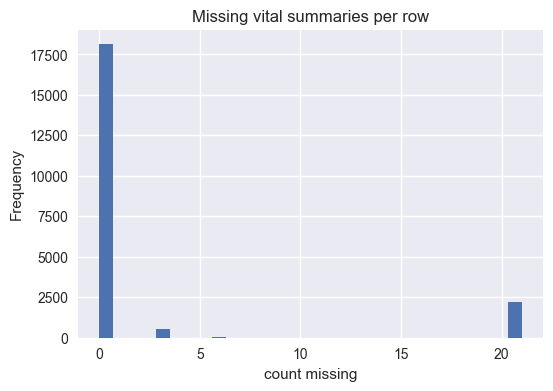

In [9]:
VITAL_COLS = [
    "HeartRate_Min", "HeartRate_Max", "HeartRate_Mean",
    "SysBP_Min", "SysBP_Max", "SysBP_Mean",
    "DiasBP_Min", "DiasBP_Max", "DiasBP_Mean",
    "MeanBP_Min", "MeanBP_Max", "MeanBP_Mean",
    "RespRate_Min", "RespRate_Max", "RespRate_Mean",
    "TempC_Min", "TempC_Max", "TempC_Mean",
    "SpO2_Min", "SpO2_Max", "SpO2_Mean",
    "Glucose_Min", "Glucose_Max", "Glucose_Mean",
]

n_missing_vitals = train_raw[VITAL_COLS].isna().sum(axis=1)
if EDA:
    plt.figure(figsize=(6,4))
    n_missing_vitals.plot(kind="hist", bins=30)
    plt.title("Missing vital summaries per row")
    plt.xlabel("count missing")


In [10]:
def drop_sparse_vitals(df: pd.DataFrame, threshold: int = 21) -> pd.DataFrame:
    df = df.copy()
    missing_counts = df[VITAL_COLS].isna().sum(axis=1)
    keep_mask = missing_counts < threshold
    print(f"Dropping {(~keep_mask).sum()} rows with >= {threshold} missing vital features")
    return df.loc[keep_mask].reset_index(drop=True)

train_clean = drop_sparse_vitals(train_raw)
test_clean = test_raw.copy()
print("train_clean shape:", train_clean.shape)


Dropping 2183 rows with >= 21 missing vital features
train_clean shape: (18702, 44)


### 4. Target imbalance
Mortality is ~11%; note class imbalance for modeling.


HOSPITAL_EXPIRE_FLAG
0    0.887819
1    0.112181
Name: proportion, dtype: float64


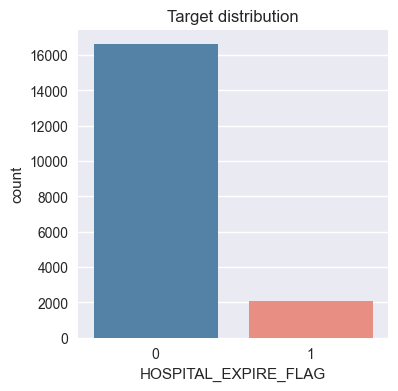

In [11]:
if "HOSPITAL_EXPIRE_FLAG" in train_clean:
    print(train_clean["HOSPITAL_EXPIRE_FLAG"].value_counts(normalize=True))
    if EDA:
        plt.figure(figsize=(4,4))
        sns.countplot(x="HOSPITAL_EXPIRE_FLAG", data=train_clean, palette=["steelblue", "salmon"])
        plt.title("Target distribution")


### 5. Vital summaries: stats and correlations


In [12]:
vital_means = [c for c in VITAL_COLS if c.endswith("_Mean") and c in train_clean.columns]
train_clean[vital_means].describe()


,HeartRate_Mean,SysBP_Mean,DiasBP_Mean,MeanBP_Mean,RespRate_Mean,TempC_Mean,SpO2_Mean,Glucose_Mean
count,18698.000000,18677.000000,18676.000000,18699.000000,18696.000000,18388.000000,18682.000000,18449.000000
mean,85.180250,119.145423,62.511614,77.609535,18.985855,36.751717,96.866685,139.033918
std,15.318208,16.701503,11.010790,11.113299,3.849713,0.603476,2.333108,44.437267
min,34.714286,46.000000,17.000000,25.759907,9.291667,30.666667,47.666667,43.250000
25%,74.272727,107.100000,54.950952,70.033908,16.250000,36.388889,95.812500,111.000000
50%,84.131183,116.901961,61.423660,76.294118,18.382353,36.731481,97.142857,129.000000
75%,95.185588,129.465116,68.954545,84.041774,21.105543,37.092593,98.346154,155.000000
max,163.875000,202.172414,121.489362,136.652174,41.235294,40.238333,100.000000,771.900000


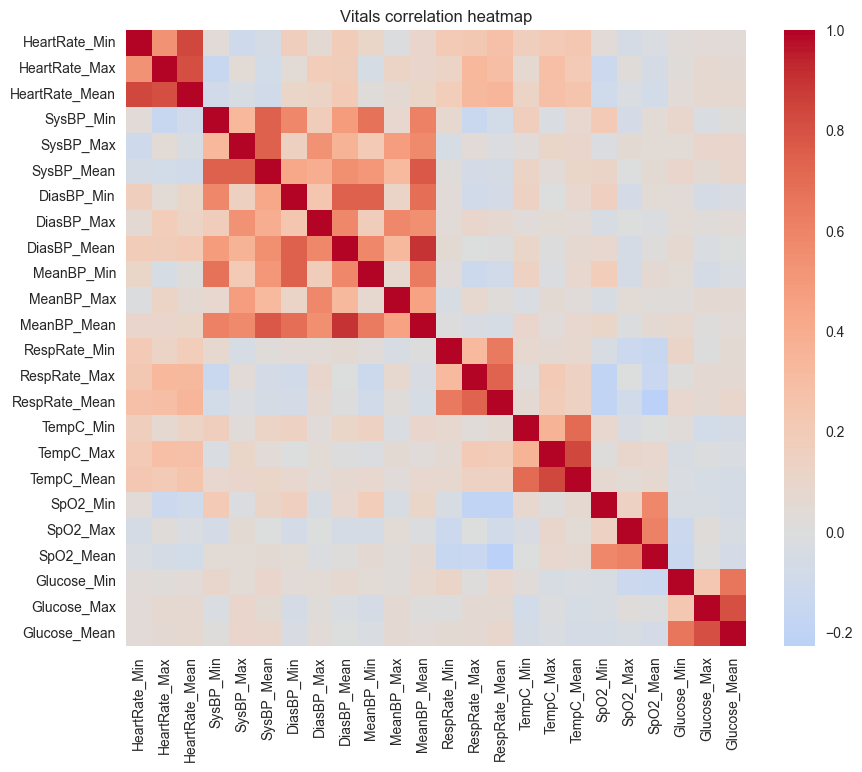

In [13]:
if EDA:
    corr = train_clean[[c for c in VITAL_COLS if c in train_clean.columns]].corr()
    plt.figure(figsize=(10,8))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Vitals correlation heatmap")


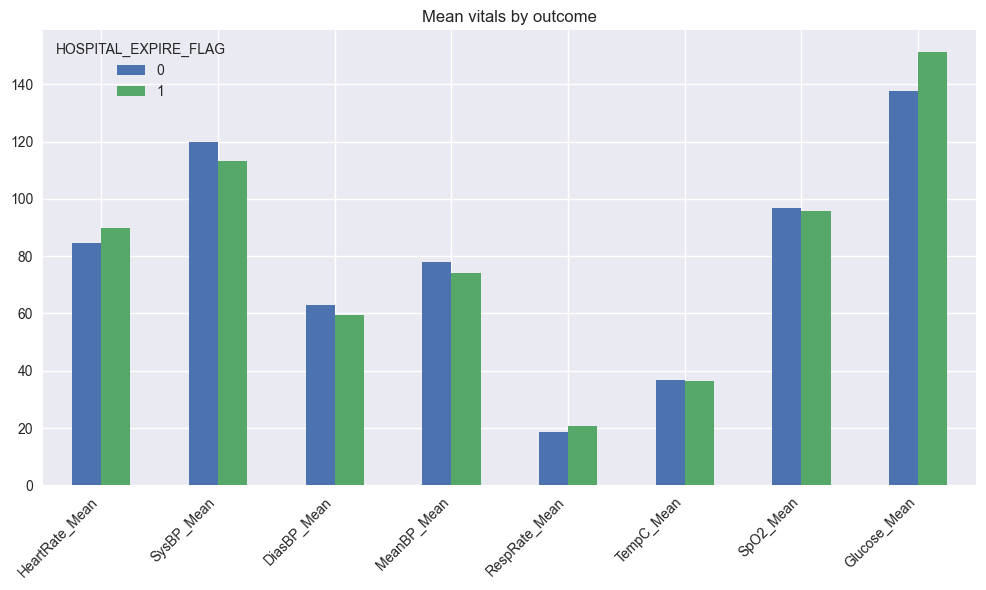

In [14]:
if EDA and "HOSPITAL_EXPIRE_FLAG" in train_clean:
    grouped_vitals = train_clean.groupby("HOSPITAL_EXPIRE_FLAG")[vital_means].mean().T
    grouped_vitals.plot(kind="bar", figsize=(10,6))
    plt.title("Mean vitals by outcome")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()


### 6. Age at admission


In [ ]:
from pandas import to_datetime

def add_age_at_admission(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    for col in ["DOB", "ADMITTIME"]:
        df[col] = to_datetime(df[col], errors="coerce")
    
    # Compute age using year arithmetic to avoid overflow
    dob = df["DOB"]
    admit = df["ADMITTIME"]
    
    # Calculate years: base difference + adjustment for birthday
    years = admit.dt.year - dob.dt.year
    had_birthday = (admit.dt.month > dob.dt.month) | ((admit.dt.month == dob.dt.month) & (admit.dt.day >= dob.dt.day))
    df["age_at_admission"] = years.where(had_birthday, years - 1).astype(float)
    
    # Set invalid ages (< 0 or > 110) to NaN
    mask_invalid = (df["age_at_admission"] < 0) | (df["age_at_admission"] > 110)
    df.loc[mask_invalid, "age_at_admission"] = np.nan
    
    return df

train_age = add_age_at_admission(train_clean)
test_age = add_age_at_admission(test_clean)

if EDA:
    plt.figure(figsize=(6,4))
    sns.histplot(train_age["age_at_admission"], bins=40, kde=True)
    plt.title("Age at admission")


OverflowError: Overflow in int64 addition

### 7. Categorical distributions and target lift


In [ ]:
demographic_cols = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "FIRST_CAREUNIT"]

if EDA:
    for col in demographic_cols:
        if col in train_age.columns:
            print(f"
=== {col} ===")
            print(train_age[col].value_counts(normalize=True).head(10))
            plt.figure(figsize=(6,3))
            sns.countplot(y=col, data=train_age, order=train_age[col].value_counts().index)
            plt.title(col)
            plt.tight_layout()

    cat_for_target = [c for c in ["GENDER","ETHNICITY","INSURANCE","FIRST_CAREUNIT"] if c in train_age.columns]
    for col in cat_for_target:
        plt.figure(figsize=(6,3))
        sns.barplot(x=col, y="HOSPITAL_EXPIRE_FLAG", data=train_age, estimator=np.mean)
        plt.title(f"Mortality rate by {col}")
        plt.xticks(rotation=45, ha="right")
        plt.tight_layout()


### 8. Diagnosis severity features (Bayesian smoothing) + EDA
Rationale: mortality rate per ICD9, smoothed to avoid overfitting rare codes.


In [ ]:
def fit_diagnosis_features(train_df: pd.DataFrame, diagnoses_df: pd.DataFrame, alpha: int = 10):
    df = train_df.copy()
    diag = diagnoses_df.copy()
    diag["HADM_ID"] = diag["HADM_ID"].astype(int)
    diag["SEQ_NUM"] = diag["SEQ_NUM"].astype(float)

    merged = diag.merge(df[["hadm_id", "HOSPITAL_EXPIRE_FLAG"]], left_on="HADM_ID", right_on="hadm_id", how="left")
    merged = merged.dropna(subset=["HOSPITAL_EXPIRE_FLAG"])

    overall_mortality = merged["HOSPITAL_EXPIRE_FLAG"].mean()
    by_code = merged.groupby("ICD9_CODE")["HOSPITAL_EXPIRE_FLAG"].agg(["mean", "count"])
    by_code["severity"] = (by_code["count"] * by_code["mean"] + alpha * overall_mortality) / (by_code["count"] + alpha)
    severity_map = by_code["severity"].to_dict()

    merged["severity_score"] = merged["ICD9_CODE"].map(severity_map).fillna(overall_mortality)

    agg = merged.groupby("HADM_ID").agg(
        diagnosis_count=("ICD9_CODE", "count"),
        avg_diagnosis_severity=("severity_score", "mean"),
        max_diagnosis_severity=("severity_score", "max"),
    )

    primary = merged.loc[merged["SEQ_NUM"] == 1, ["HADM_ID", "severity_score"]].rename(columns={"severity_score": "primary_diagnosis_severity"})
    agg = agg.merge(primary, on="HADM_ID", how="left")
    agg["primary_diagnosis_severity"] = agg["primary_diagnosis_severity"].fillna(overall_mortality)

    df = df.merge(agg, left_on="hadm_id", right_on="HADM_ID", how="left")
    df["diagnosis_count"] = df["diagnosis_count"].fillna(0)
    for col in ["avg_diagnosis_severity", "max_diagnosis_severity", "primary_diagnosis_severity"]:
        df[col] = df[col].fillna(overall_mortality)

    state = {"severity_map": severity_map, "overall_mortality": overall_mortality, "alpha": alpha}
    return df.drop(columns=["HADM_ID"], errors="ignore"), state


def apply_diagnosis_features(df: pd.DataFrame, diagnoses_df: pd.DataFrame, state: dict):
    df = df.copy()
    diag = diagnoses_df.copy()
    diag["HADM_ID"] = diag["HADM_ID"].astype(int)
    diag["SEQ_NUM"] = diag["SEQ_NUM"].astype(float)

    diag["severity_score"] = diag["ICD9_CODE"].map(state["severity_map"]).fillna(state["overall_mortality"])

    agg = diag.groupby("HADM_ID").agg(
        diagnosis_count=("ICD9_CODE", "count"),
        avg_diagnosis_severity=("severity_score", "mean"),
        max_diagnosis_severity=("severity_score", "max"),
    )

    primary = diag.loc[diag["SEQ_NUM"] == 1, ["HADM_ID", "severity_score"]].rename(columns={"severity_score": "primary_diagnosis_severity"})
    agg = agg.merge(primary, on="HADM_ID", how="left")
    agg["primary_diagnosis_severity"] = agg["primary_diagnosis_severity"].fillna(state["overall_mortality"])

    df = df.merge(agg, left_on="hadm_id", right_on="HADM_ID", how="left")
    df["diagnosis_count"] = df["diagnosis_count"].fillna(0)
    for col in ["avg_diagnosis_severity", "max_diagnosis_severity", "primary_diagnosis_severity"]:
        df[col] = df[col].fillna(state["overall_mortality"])

    return df.drop(columns=["HADM_ID"], errors="ignore")


In [ ]:
train_diag, diag_state = fit_diagnosis_features(train_age, diagnoses_raw)
print("Overall mortality used for smoothing:", diag_state["overall_mortality"])

test_diag = apply_diagnosis_features(test_age, diagnoses_raw, diag_state)
train_diag[["diagnosis_count", "avg_diagnosis_severity", "max_diagnosis_severity", "primary_diagnosis_severity"]].describe()


### Diagnosis EDA for presentation


In [ ]:
if EDA:
    # Distribution of diagnoses per patient
    plt.figure(figsize=(6,4))
    sns.histplot(train_diag["diagnosis_count"], bins=30)
    plt.title("Diagnoses per ICU stay")

    # Top primary diagnoses
    primary_diag = diagnoses_raw[diagnoses_raw["SEQ_NUM"] == 1]
    top_primary = primary_diag["ICD9_CODE"].value_counts().head(20)
    plt.figure(figsize=(8,5))
    top_primary.plot(kind="bar")
    plt.title("Top 20 primary ICD9 codes")
    plt.xticks(rotation=45, ha="right")

    # Diagnosis count vs mortality
    bins = pd.cut(train_diag["diagnosis_count"], bins=[0,5,10,15,20,25,30,40])
    mort_by_bin = train_diag.groupby(bins)["HOSPITAL_EXPIRE_FLAG"].mean()
    plt.figure(figsize=(7,4))
    mort_by_bin.plot(kind="bar")
    plt.title("Mortality rate by diagnosis count bin")

    # Severity quartiles vs mortality
    severity_q = pd.qcut(train_diag["avg_diagnosis_severity"], 4, labels=False, duplicates="drop")
    mort_by_sev = train_diag.groupby(severity_q)["HOSPITAL_EXPIRE_FLAG"].mean()
    plt.figure(figsize=(6,3))
    mort_by_sev.plot(kind="bar")
    plt.title("Mortality by avg severity quartile")


### 9. Preprocessing (impute -> encode -> scale)


In [ ]:
target_col = "HOSPITAL_EXPIRE_FLAG"
categorical_cols = ["GENDER", "ADMISSION_TYPE", "INSURANCE", "RELIGION", "MARITAL_STATUS", "ETHNICITY", "FIRST_CAREUNIT"]
drop_cols = ["subject_id", "hadm_id", "icustay_id", "DOB", "ADMITTIME", "DISCHTIME", "DOD", "DEATHTIME", "LOS", "DIAGNOSIS", "ICD9_diagnosis"]


In [ ]:
def fit_preprocessing_pipeline(df: pd.DataFrame, target_col: str):
    df = df.copy()
    y = df[target_col].astype(int)
    X = df.drop(columns=[target_col])
    X = X.drop(columns=[c for c in drop_cols if c in X.columns], errors="ignore")

    cat_cols = [c for c in categorical_cols if c in X.columns]
    num_cols = [c for c in X.columns if c not in cat_cols]

    num_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
    cat_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="most_frequent")), ("encoder", OneHotEncoder(handle_unknown="ignore", drop="first"))])

    preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_cols), ("cat", cat_transformer, cat_cols)], remainder="drop")

    X_processed = preprocessor.fit_transform(X)

    feature_names = []
    if len(cat_cols) > 0:
        enc = preprocessor.named_transformers_["cat"].named_steps["encoder"]
        feature_names.extend(enc.get_feature_names_out(cat_cols))
    feature_names.extend(num_cols)

    state = {"preprocessor": preprocessor, "feature_names": feature_names, "cat_cols": cat_cols, "num_cols": num_cols}
    return X_processed, y, state


def apply_preprocessing_pipeline(df: pd.DataFrame, state: dict):
    X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")
    preprocessor = state["preprocessor"]
    return preprocessor.transform(X)


In [ ]:
X_train, y_train, preprocess_state = fit_preprocessing_pipeline(train_diag, target_col)
print("Processed train shape:", X_train.shape)
print("Positive rate:", y_train.mean())


### 10. Models + CV
ROC-AUC primary; PR-AUC secondary for class imbalance.


In [ ]:
def evaluate_models_cv(models: dict, X, y, cv_splits: int = 5):
    cv = StratifiedKFold(n_splits=cv_splits, shuffle=True, random_state=RANDOM_STATE)
    results = {}
    for name, model in models.items():
        auc_scores = cross_val_score(model, X, y, cv=cv, scoring="roc_auc", n_jobs=-1)
        pr_scores = cross_val_score(model, X, y, cv=cv, scoring="average_precision", n_jobs=-1)
        results[name] = {
            "roc_auc_mean": auc_scores.mean(),
            "roc_auc_std": auc_scores.std(),
            "pr_auc_mean": pr_scores.mean(),
            "pr_auc_std": pr_scores.std(),
        }
    return pd.DataFrame(results).T.sort_values(by="roc_auc_mean", ascending=False)


In [ ]:
imbalance_weight = (y_train == 0).sum() / (y_train == 1).sum()
models = {
    "log_reg": LogisticRegression(max_iter=500, class_weight="balanced", n_jobs=-1),
    "random_forest": RandomForestClassifier(
        n_estimators=200,
        max_depth=None,
        min_samples_leaf=2,
        class_weight="balanced",
        random_state=RANDOM_STATE,
        n_jobs=-1,
    ),
}

if HAS_XGB:
    models["xgboost"] = XGBClassifier(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.9,
        colsample_bytree=0.9,
        objective="binary:logistic",
        eval_metric="auc",
        scale_pos_weight=float(imbalance_weight),
        random_state=RANDOM_STATE,
        n_jobs=-1,
    )
else:
    print("xgboost not installed in this env. Install if you want that model: pip install xgboost")


In [ ]:
cv_results = evaluate_models_cv(models, X_train, y_train)
cv_results


### 11. Optional grid search (XGBoost)


In [ ]:
RUN_GRIDSEARCH = False
if RUN_GRIDSEARCH and HAS_XGB:
    param_grid = {
        "n_estimators": [150, 250, 300],
        "max_depth": [3, 5, 7],
        "learning_rate": [0.03, 0.05, 0.1],
        "subsample": [0.8, 1.0],
        "colsample_bytree": [0.8, 1.0],
    }
    xgb = models["xgboost"]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring="roc_auc", cv=cv, n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    print("Best params:", grid.best_params_)
    print("Best ROC-AUC:", grid.best_score_)
    best_estimator = grid.best_estimator_
else:
    best_estimator = None


### 12. Final fit


In [ ]:
if best_estimator is None:
    best_model_name = cv_results.index[0]
    best_model = clone(models[best_model_name])
else:
    best_model_name = "xgboost_tuned"
    best_model = best_estimator

best_model.fit(X_train, y_train)
print(f"Fitted {best_model_name} on full training set")


### 13. Feature importance peek


In [ ]:
feature_names = preprocess_state.get("feature_names", [])

if hasattr(best_model, "feature_importances_"):
    importances = pd.Series(best_model.feature_importances_, index=feature_names)
    display(importances.sort_values(ascending=False).head(20))
elif hasattr(best_model, "coef_"):
    coefs = pd.Series(best_model.coef_[0], index=feature_names)
    display(coefs.sort_values(key=abs, ascending=False).head(20))
else:
    print("Model does not expose feature importances directly.")


### 14. Test-set preprocessing + submission


In [ ]:
X_test = apply_preprocessing_pipeline(test_diag, preprocess_state)
test_predictions = best_model.predict_proba(X_test)[:, 1]

submission = pd.DataFrame({
    "icustay_id": test_diag["icustay_id"],
    "prediction": test_predictions,
})
submission.to_csv("argote_mariajose_CML_2025.csv", index=False)

print(submission.head())
print("Saved submission -> argote_mariajose_CML_2025.csv")


### 15. Quick recap
- Kept EDA (missingness, imbalance, vitals, age, categorical, diagnoses) to defend choices.
- Bayesian-smoothed severity features to stabilize rare ICD9 codes.
- Impute -> encode -> scale pipeline, stratified CV, class weighting.
- Flip EDA/gridsearch flags as needed before final run.
